In [1]:
import numpy as np
import pandas as pd
import gym
import random
import time
import math
import copy
import pickle
from gym.core import Wrapper
from pickle import dumps, loads
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy import stats

### Classes and functions:

In [2]:
class EnvWithSnapShots(Wrapper):
    '''
    A wrapper to allow for taking\loading snapshots of the game environment.
    It also allows for performing an action on a given snapshot and return the resulting game snapshot along with the original return values. 
    '''
    
    def get_snapshot(self):
        return dumps(self.env)
    
    def load_snapshot(self, snapshot):
        self.env = loads(snapshot)
    
    def perform_action(self, snapshot , action):
        self.load_snapshot(snapshot)
        next_state, reward, done, info = self.step(action)
        next_snapshot = self.get_snapshot()
        
        return (next_snapshot, next_state, reward, done, info)

In [3]:
class MCTSNode():
    '''
    The Search Tree Nodes and their associated operations.
    '''
    def __init__(self, parent_snapshot, parent=None, move= None, gamma= 0.95, alpha=0.01, w_td =0.5, C=1):
        self.is_fully_expanded = False
        self.move = move
        self.parent = parent
        self.children = set()
        self.TD_Q = 0
        self.total_value = 0
        self.number_visits = 0
        self.terminal = False
        self.reward = 0
        self.gamma = gamma
        self.w_td = w_td
        self.C = C
        self.alpha = alpha
        
        # get its game snapshot by performing the action on the parent node's game snapshot
        if parent is not None:
            self.snapshot, self.state, self.reward, self.terminal, _ = env.perform_action(parent_snapshot, self.move)
        else: # if it is the root node, get the passed on snapshot which is the start of the game
            self.snapshot = parent_snapshot  
        
    def get_mean_value(self):
        return self.total_value / self.number_visits if self.number_visits != 0 else 0
    
    def get_TD_UCB1(self, w_td=None, C=None, infinity = 1e100):
        if w_td == None: w_td= self.w_td
        if C == None: C= self.C
            
        if self.number_visits == 0:
            return infinity
        else:
            Q = self.get_mean_value()
            U = np.sqrt(2*np.log(self.parent.number_visits) / (self.number_visits))
            return w_td*self.TD_Q + (1.0-w_td)*Q + C*U

    def choose_child(self):         
        return max(self.children , key=MCTSNode.get_TD_UCB1)

    def select(self):
        if not self.terminal:
            if not self.is_fully_expanded:
                return self.expand()
            else:
                child = self.choose_child()
                return child.select()
        else:
            return self
    
    def expand(self):
        not_visited_children = list(range(env.action_space.n))
        for child in self.children:
            not_visited_children.remove(child.move)
        child = self.add_child(random.choice(not_visited_children))
        if len(self.children) == env.action_space.n:
            self.is_fully_expanded = True
        return child

    def add_child(self, move):
        child = MCTSNode(self.snapshot ,parent = self , move = move, gamma= self.gamma,
                                                 alpha=self.alpha, w_td = self.w_td, C=self.C)
        self.children.add(child)
        return child
    
    def rollout(self):
        env.load_snapshot(self.snapshot)
        done = self.terminal
        steps = 0
        reward = 0
        while not done: 
            _, reward, done, _ = env.step(env.action_space.sample())
            steps += 1
        return reward, steps
    
    def backpropagate(self, value_estimate, TD_Q , steps, leaf=True):
        self.total_value += value_estimate
        self.number_visits += 1
        # updating its V_td
        if leaf: self.TD_Q = (1-self.alpha)*self.TD_Q + self.alpha*(self.reward + (self.gamma**steps)*value_estimate)
        else: self.TD_Q = (1-self.alpha)*self.TD_Q + self.alpha*(self.reward + self.gamma*TD_Q)
        # back them up if there is a parent
        if self.parent is not None:
            self.parent.backpropagate(value_estimate, self.TD_Q, steps, leaf=False)
            
    def best_child(self):
        Q_vals = [child.get_TD_UCB1(C = 0) for child in self.children]
        m = max(Q_vals)
        child = random.choice([child for child in self.children if child.get_TD_UCB1(C = 0) == m])
        return child 

In [4]:
# The main function for the Monte Carlo Tree Search 
def monte_carlo_tree_search(starting_env, iterations, gamma= 0.95, alpha=0.01, w_td =0.5, C=1): 
    root = MCTSNode(starting_env, gamma= gamma, alpha=alpha, w_td = w_td, C=C)
    for _ in range(iterations): 
        leaf = root.select()
        simulation_result, steps = leaf.rollout() 
        leaf.backpropagate(simulation_result, 0, steps)
    return root.best_child() 

In [5]:
def evaluate_MCTS(env, n_episodes, simulation_range, show_game=False, gamma= 0.95, alpha=0.01, w_td =0.5, C=1):
    '''
    This function is made for obtianing the results of using different parameters.
    
    Variables:
    env: the instatiated gym environment object
    n_episodes: an integer indicating the number of times each setupe is run untill completion (the number of game plays)
    simulation_range : a range of the number of simulations run before taking a move
    show_game : a boolean indicating wether to show the game board and the results or not. defult = False
    '''
    max_steps_per_episode = 100
    
    sims = list(simulation_range)
    columns = ['Won', 'n_steps_before_winning_mean', 'n_steps_before_winning_standardError']
    Results = pd.DataFrame(index=sims, columns=columns)
    
    for sim_trial in simulation_range:
        print('Number of simulations per move: ', sim_trial)
    
        losses = 0
        wins = 0
        steps = []

        for episode in range(n_episodes):
            state = env.reset()
            done = False
            
            if show_game:
                print("*****EPISODE ", episode+1, "*****\n\n\n\n")
                time.sleep(1)

            for step in range(max_steps_per_episode):   
                if show_game:
                    clear_output(wait=True)
                    env.render()
                    print('thinking...')
                    time.sleep(0.3)
                    
                env_snapshot = env.get_snapshot()
                action = monte_carlo_tree_search(env_snapshot, sim_trial, gamma= gamma, alpha=alpha, w_td = w_td, C=C).move   
                env.load_snapshot(env_snapshot)
                new_state, reward, done, info = env.step(action)
                
                if show_game:
                    clear_output(wait=True)
                    env.render()

                if done:
                    if reward == 1:
                        wins += 1
                        steps.append(step+1)
                        
                        if show_game:
                            print("****You won!****")
                            print("Number of steps", step+1)
                            time.sleep(3)
                            clear_output(wait=True)
                    else:
                        losses += 1
                        
                        if show_game:
                            print("****You lost!****")
                            time.sleep(3)
                            clear_output(wait=True)
                    break

        env.close()
        
        Results.loc[sim_trial , 'Won'] = wins/(n_episodes)
        Results.loc[sim_trial , 'n_steps_before_winning_mean'] = np.mean(steps)
        Results.loc[sim_trial , 'n_steps_before_winning_standardError'] = np.std(steps)/np.sqrt(n_episodes)
        
        print( 'Losses : '+str(losses)+'\t wins : '+str(wins)+' \t Presentage : '+str((wins /(n_episodes))*100)+'%')
        print('Average number of steps before winning: '+str(np.mean(steps)))
        print('Standard Error of the number of steps before winning: '+str(np.std(steps)/np.sqrt(wins)))
        print('---')
        
    return Results

---

### Some of the experiments and the results:

#### Varying $\alpha$:

In [47]:
env = EnvWithSnapShots(gym.make("FrozenLake-v0", is_slippery=True))

param = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
columns = ['Won', 'n_steps_before_winning_mean', 'n_steps_before_winning_standardError']
Results_alpha = pd.DataFrame(index=param, columns=columns)
for alpha in param:
    Results_TDUCT = evaluate_MCTS(env, n_episodes = 500, simulation_range = range(500,501), show_game=False, w_td=1, gamma= 0.95, alpha=alpha, C=1)
    Results_alpha.loc[alpha, 'Won'] = Results_TDUCT.iloc[0,0]
    Results_alpha.loc[alpha, 'n_steps_before_winning_mean'] = Results_TDUCT.iloc[0,1]
    Results_alpha.loc[alpha, 'n_steps_before_winning_standardError'] = Results_TDUCT.iloc[0,2]

Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 9.462
Standard Error of the number of steps before winning: 0.15393866310969445
---
Number of simulations per move:  500
Losses : 1	 wins : 499 	 Presentage : 99.8%
Average number of steps before winning: 9.162324649298597
Standard Error of the number of steps before winning: 0.15656743661762645
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 8.216
Standard Error of the number of steps before winning: 0.11434460197140922
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.64
Standard Error of the number of steps before winning: 0.09738993787861248
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.884
Standard Error of the number of steps 

In [48]:
Results_alpha

,Won,n_steps_before_winning_mean,n_steps_before_winning_standardError
0.001,1,9.462,0.153939
0.010,0.998,9.16232,0.156411
0.100,1,8.216,0.114345
0.200,1,7.64,0.0973899
0.300,1,7.884,0.10437
0.400,1,8.67,0.125484
0.500,0.998,9.98998,0.183955


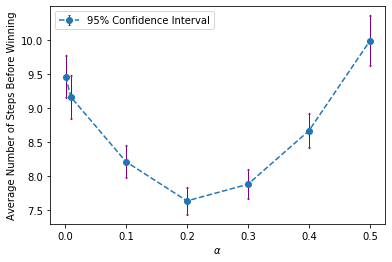

In [9]:
x = Results_alpha.index.values
y = Results_alpha['n_steps_before_winning_mean']
yerr = 1.96*Results_alpha['n_steps_before_winning_standardError']
plt.errorbar(x, y, yerr=yerr, elinewidth= 1,capsize=0.9, capthick=0.9, ecolor='purple', fmt='o--',uplims=True, lolims=True , label='95% Confidence Interval')
plt.xlabel(r'$\alpha$')
plt.ylabel('Average Number of Steps Before Winning')
plt.legend()
# plt.savefig('alpha.pdf', dpi=500, bbox_inches='tight')

#### Varying $\gamma$ :

In [14]:
env = EnvWithSnapShots(gym.make("FrozenLake-v0", is_slippery=True))

param = np.arange(0.05,1.05,0.15)
columns = ['Won', 'n_steps_before_winning_mean', 'n_steps_before_winning_standardError']
Results_gamma = pd.DataFrame(index=param, columns=columns)
for gamma in param:
    Results_TDUCT = evaluate_MCTS(env, n_episodes=500, simulation_range = range(500,501), show_game=False, w_td=1, gamma = gamma, alpha=0.2, C=1)
    Results_gamma.loc[gamma, 'Won'] = Results_TDUCT.iloc[0,0]
    Results_gamma.loc[gamma, 'n_steps_before_winning_mean'] = Results_TDUCT.iloc[0,1]
    Results_gamma.loc[gamma, 'n_steps_before_winning_standardError'] = Results_TDUCT.iloc[0,2]

Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 6.634
Standard Error of the number of steps before winning: 0.043909998861307205
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 6.536
Standard Error of the number of steps before winning: 0.039311677654356086
---
Number of simulations per move:  500
Losses : 1	 wins : 499 	 Presentage : 99.8%
Average number of steps before winning: 6.653306613226453
Standard Error of the number of steps before winning: 0.04805534521677587
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 6.7
Standard Error of the number of steps before winning: 0.05495452665613634
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 6.784
Standard Error of the number of steps

In [15]:
Results_gamma

,Won,n_steps_before_winning_mean,n_steps_before_winning_standardError
0.05,1,6.634,0.04391
0.20,1,6.536,0.0393117
0.35,0.998,6.65331,0.0480073
0.50,1,6.7,0.0549545
0.65,1,6.784,0.0553054
0.80,1,7.12,0.0673736
0.95,1,7.816,0.0993393


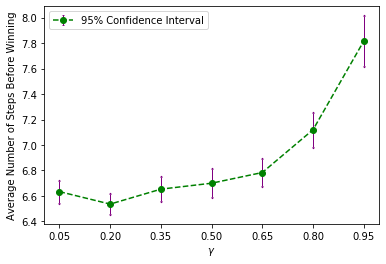

In [33]:
x = Results_gamma.index.values
y = Results_gamma['n_steps_before_winning_mean']
yerr = 1.96*Results_gamma['n_steps_before_winning_standardError']
plt.errorbar(x, y, yerr=yerr, elinewidth= 1,capsize=0.9, capthick=0.9, ecolor='purple', fmt='go--',uplims=True, lolims=True, label='95% Confidence Interval')
plt.xticks(x)
plt.xlabel(r'$\gamma$')
plt.ylabel('Average Number of Steps Before Winning')
plt.legend()
# plt.savefig('gamma.pdf', dpi=500, bbox_inches='tight')

#### Varying $w_{td}$:

In [6]:
env = EnvWithSnapShots(gym.make("FrozenLake-v0", is_slippery=True))

param = np.arange(0 , 1.1 , 0.1)
columns = ['Won', 'n_steps_before_winning_mean', 'n_steps_before_winning_standardError']
Results_wtd = pd.DataFrame(index=param, columns=columns)
for wtd in param:
    Results_TDUCT = evaluate_MCTS(env, n_episodes=500, simulation_range = range(500,501), show_game= False, w_td= wtd, discount= 0.2, alpha= 0.2, C=1)
    Results_wtd.loc[wtd, 'Won'] = Results_TDUCT.iloc[0,0]
    Results_wtd.loc[wtd, 'n_steps_before_winning_mean'] = Results_TDUCT.iloc[0,1]
    Results_wtd.loc[wtd, 'n_steps_before_winning_standardError'] = Results_TDUCT.iloc[0,2]

Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.43
Standard Error of the number of steps before winning: 0.07553939369626948
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.422
Standard Error of the number of steps before winning: 0.07647111873119158
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.344
Standard Error of the number of steps before winning: 0.08180053789554198
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.2
Standard Error of the number of steps before winning: 0.07563068160475615
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.474
Standard Error of the number of steps before winnin

In [7]:
Results_wtd

,Won,n_steps_before_winning_mean,n_steps_before_winning_standardError
0.0,1,7.43,0.0755394
0.1,1,7.422,0.0764711
0.2,1,7.344,0.0818005
0.3,1,7.2,0.0756307
0.4,1,7.474,0.0886941
0.5,1,7.464,0.0876436
0.6,1,7.528,0.0866397
0.7,1,7.648,0.0915215
0.8,1,7.614,0.0864061
0.9,1,7.568,0.0890098


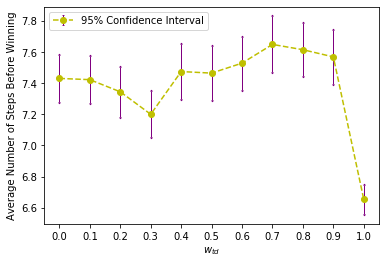

In [10]:
x = Results_wtd.index.values
y = Results_wtd['n_steps_before_winning_mean']
yerr = 1.96*Results_wtd['n_steps_before_winning_standardError']
plt.errorbar(x, y, yerr=yerr, elinewidth= 1,capsize=0.9, capthick=0.9, ecolor='purple', fmt='yo--',uplims=True, lolims=True, label='95% Confidence Interval')
plt.xticks(x)
plt.xlabel(r'$w_{td}$')
plt.ylabel('Average Number of Steps Before Winning')
plt.legend()
# plt.savefig('wtd.pdf', dpi=500, bbox_inches='tight')

### Evaluating $w_{td} = 0.0$, $w_{td} = 0.3$ and $w_{td} = 1.0$ as the number of simulations per move changes:

In [7]:
env = EnvWithSnapShots(gym.make("FrozenLake-v0", is_slippery=True))

Results_wtd0 = evaluate_MCTS(env, n_episodes=500, simulation_range = range(100,1100,100), show_game= False, w_td= 0, discount= 0.2, alpha= 0.2, C=1)

Number of simulations per move:  100
Losses : 57	 wins : 443 	 Presentage : 88.6%
Average number of steps before winning: 9.483069977426636
Standard Error of the number of steps before winning: 0.16555100712187099
---
Number of simulations per move:  200
Losses : 14	 wins : 486 	 Presentage : 97.2%
Average number of steps before winning: 8.320987654320987
Standard Error of the number of steps before winning: 0.12245695832261973
---
Number of simulations per move:  300
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.842
Standard Error of the number of steps before winning: 0.10389452343603102
---
Number of simulations per move:  400
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.712
Standard Error of the number of steps before winning: 0.09819425645117946
---
Number of simulations per move:  500
Losses : 1	 wins : 499 	 Presentage : 99.8%
Average number of steps before winning: 7.458917835671342
Standard Erro

In [14]:
Results_wtd0

,Won,n_steps_before_winning_mean,n_steps_before_winning_standardError
100,0.886,9.48307,0.155829
200,0.972,8.32099,0.12073
300,1,7.842,0.103895
400,1,7.712,0.0981943
500,0.998,7.45892,0.0812702
600,1,7.104,0.0696446
700,1,7.054,0.0709801
800,1,6.842,0.0567985
900,1,6.872,0.0538074
1000,1,6.668,0.0486164


In [6]:
env = EnvWithSnapShots(gym.make("FrozenLake-v0", is_slippery=True))

Results_wtd03 = evaluate_MCTS(env, n_episodes=500, simulation_range = range(100,1100,100), show_game= False, w_td= 0.3, discount= 0.2, alpha= 0.2, C=1)

Number of simulations per move:  100
Losses : 66	 wins : 434 	 Presentage : 86.8%
Average number of steps before winning: 9.080645161290322
Standard Error of the number of steps before winning: 0.1772573534630442
---
Number of simulations per move:  200
Losses : 15	 wins : 485 	 Presentage : 97.0%
Average number of steps before winning: 8.542268041237113
Standard Error of the number of steps before winning: 0.1330237869686384
---
Number of simulations per move:  300
Losses : 4	 wins : 496 	 Presentage : 99.2%
Average number of steps before winning: 7.69758064516129
Standard Error of the number of steps before winning: 0.09453553780284672
---
Number of simulations per move:  400
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.482
Standard Error of the number of steps before winning: 0.08608920954451842
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 7.196
Standard Error o

In [7]:
Results_wtd03

,Won,n_steps_before_winning_mean,n_steps_before_winning_standardError
100,0.868,9.08065,0.165145
200,0.97,8.54227,0.131013
300,0.992,7.69758,0.0941566
400,1,7.482,0.0860892
500,1,7.196,0.0758101
600,1,7.276,0.077509
700,1,7.07,0.0631997
800,1,7.032,0.0621446
900,1,6.938,0.0564651
1000,1,6.726,0.0515931


In [6]:
env = EnvWithSnapShots(gym.make("FrozenLake-v0", is_slippery=True))

Results_wtd1 = evaluate_MCTS(env, n_episodes=500, simulation_range = range(100,1100,100), show_game= False, w_td= 1, discount= 0.2, alpha= 0.2, C=1)

Number of simulations per move:  100
Losses : 59	 wins : 441 	 Presentage : 88.2%
Average number of steps before winning: 8.53968253968254
Standard Error of the number of steps before winning: 0.13092279226255313
---
Number of simulations per move:  200
Losses : 22	 wins : 478 	 Presentage : 95.6%
Average number of steps before winning: 7.619246861924686
Standard Error of the number of steps before winning: 0.08833068378127011
---
Number of simulations per move:  300
Losses : 2	 wins : 498 	 Presentage : 99.6%
Average number of steps before winning: 7.106425702811245
Standard Error of the number of steps before winning: 0.06694188358399965
---
Number of simulations per move:  400
Losses : 1	 wins : 499 	 Presentage : 99.8%
Average number of steps before winning: 6.839679358717435
Standard Error of the number of steps before winning: 0.060492313872591026
---
Number of simulations per move:  500
Losses : 0	 wins : 500 	 Presentage : 100.0%
Average number of steps before winning: 6.72
Sta

In [15]:
Results_wtd1

,Won,n_steps_before_winning_mean,n_steps_before_winning_standardError
100,0.882,8.53968,0.122956
200,0.956,7.61925,0.0863655
300,0.996,7.10643,0.0668079
400,0.998,6.83968,0.0604318
500,1,6.72,0.0483653
600,1,6.592,0.0427443
700,1,6.504,0.0376825
800,1,6.374,0.0329279
900,1,6.292,0.0260283
1000,1,6.258,0.0269606


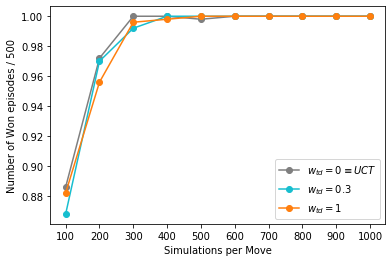

In [103]:
x = Results_wtd0.index.values
y0 = Results_wtd0['Won']
y1 = Results_wtd1['Won']
y03 = Results_wtd03['Won']

plt.plot(x, y0, marker = 'o', color='C7', label = r'$w_{td} = 0 \equiv UCT$')
plt.plot(x, y03, marker = 'o', color='C9', label = r'$w_{td} = 0.3$')
plt.plot(x, y1, marker = 'o', color='C1', label = r'$w_{td} = 1$')

plt.xticks(x)
plt.xlabel('Simulations per Move')
plt.ylabel('Number of Won episodes / 500')
plt.legend()
# plt.savefig('wtd0wtd1Acc.pdf', dpi=500, bbox_inches='tight')

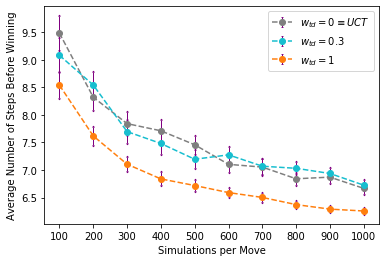

In [104]:
x = Results_wtd0.index.values
y0 = Results_wtd0['n_steps_before_winning_mean']
y03 = Results_wtd03['n_steps_before_winning_mean']
y1 = Results_wtd1['n_steps_before_winning_mean']

yerr0 = 1.96*Results_wtd0['n_steps_before_winning_standardError']
yerr03 = 1.96*Results_wtd03['n_steps_before_winning_standardError']
yerr1 = 1.96*Results_wtd1['n_steps_before_winning_standardError']

plt.errorbar(x, y0, yerr=yerr0, elinewidth= 1,capsize=0.9, capthick=0.9, ecolor='purple', fmt='C7o--',uplims=True, lolims=True, label=r'$w_{td} = 0 \equiv UCT$')
plt.errorbar(x, y03, yerr=yerr0, elinewidth= 1,capsize=0.9, capthick=0.9, ecolor='purple', fmt='C9o--',uplims=True, lolims=True, label=r'$w_{td} = 0.3$')
plt.errorbar(x, y1, yerr=yerr1, elinewidth= 1,capsize=0.9, capthick=0.9, ecolor='purple', fmt='C1o--',uplims=True, lolims=True, label=r'$w_{td} = 1$')

plt.xticks(x)
plt.xlabel('Simulations per Move')
plt.ylabel('Average Number of Steps Before Winning')
plt.legend()
# plt.savefig('wtd0wtd1.pdf', dpi=500, bbox_inches='tight')

#### The paired t-tests:

In [101]:
stats.ttest_rel(y0, y03)

Ttest_relResult(statistic=0.4647014836172124, pvalue=0.6531824549741445)

In [19]:
stats.ttest_rel(y0, y1)

Ttest_relResult(statistic=11.7154838074007, pvalue=9.443622506612187e-07)

In [102]:
stats.ttest_rel(y03, y1)

Ttest_relResult(statistic=15.057281216654653, pvalue=1.0913649660981643e-07)

### A sample game play:
##### (you can run it :D)

In [9]:
env = EnvWithSnapShots(gym.make("FrozenLake-v0", is_slippery=True))

Results_TDUCT = evaluate_MCTS(env, n_episodes=10, simulation_range = range(500,501), show_game= True, w_td= 1, gamma= 0.2, alpha= 0.2, C=1)

Losses : 0	 wins : 10 	 Presentage : 100.0%
Average number of steps before winning: 6.6
Standard Error of the number of steps before winning: 0.32249030993194194
---
